<a href="https://colab.research.google.com/github/shohail-DeV/Ai-Medical-Model/blob/main/Building_a_Medical_Image_AI_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NIH CXR8 **Classification**
We break down the process into five steps:
1. **Defining a problem**: what do we want our model to look for? For this we'll need to think of pathology we might find in a chest x-ray.
2. **Data preparation**: we'll talk about how to manipulate our data in a way the classification model can understand.
3. **Training a model**: we'll use a technology called [TensorFlow](
https://wwww.tensorflow.org) to create our model.
4. **Evaluating model performace**: we'll talk about some important considerations when creating a model like this.
5. **Deployment**: we'll send our model to a website where we can then test it in the wild and send to others.

##i. Using Google Colab

This demonstration will take place in Google Colab. Please first sign in with your Google account, and click **File -> Save a copy** in Drive.

When you get into the draft environment, please ensure that you see "GPU on" and "Internet on" under Settings so you can utilize the cloud GPU for faster model training.

In this Notebook editing environment, each block of text is referred to as a cell. Cells containing formatted text are Markdown cells, as they use the Markdown formatting language. Similarly, cells containing code are code cells.

Clicking within a cell will allow you to edit the content of that cell (a.k.a. enter edit mode). You can also navigate between cells with the arrow keys. Note that the appearance of Markdown cells will change when you enter edit mode.

You can run code cells (and format Markdown cells) as you go along by clicking within the cell and then clicking the blue button with one arrow next to the cell or at the bottom of the window. You can also use the keyboard shortcut SHIFT + ENTER (press both keys at the same time).

Let's try this out by running the cell below. This will help us load the technologies we need to power our model.

In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
Great! You clicked on it correctly. Now let's get started.


##1. Defining a Problem
Great! Let's start by thinking of something we can look for in a chest xray.

Once we think of something, let's type it in below, in between the quotes `""`, and run the cell. I'll put in `"atelectasis"` by default, but let's see if we can think of something else.

We'll be using a subset of the [NIH CXR8 dataset](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) for this project, but this principles here apply to any project. The NIH CXR8 dataset only has a few selected findings within its dataset, but let's pretend that we're creating a dataset from scratch (using Montage, e.g.). Of note, this dataset also has bounding boxes available to us for another demonstration on object detection.

We'll need to see how many examples there are of the finding we typed in. Let's run the cell below to see.

Screen Shot 2020-11-08 at 1.14.35 PM.png

Above are the labels we have available to us in this dataset.

In [2]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [3]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [5]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [6]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

## 2. Preparing the Data

Now, we've figured out what we want our model to take a look at. Behind the scenes, we just need to sort the data into two folders: one with **negative** cases and one with **positive** cases.

In [7]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [9]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [10]:
# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

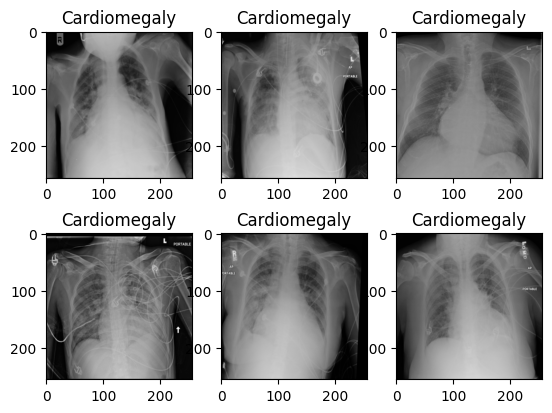

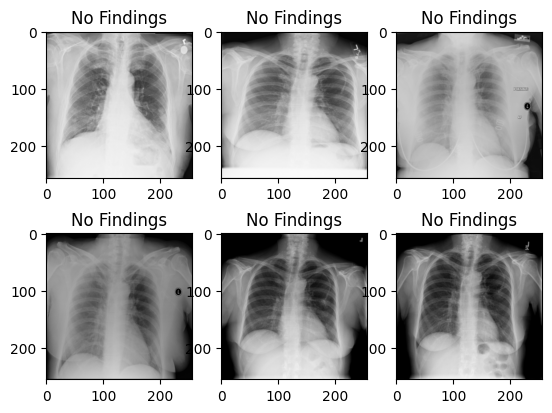

In [11]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

## 3. Training the Model

Now, we will train the model. This is the cool part.

We will be using a technology called [Inception V3](https://arxiv.org/abs/1512.00567) to look at our images. This is a model that Google created to do image analysis, and has released to the general public. It's pretty smart -- let's see how smart it is on our images.

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This particular model was trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes).

In [12]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

87910968/87910968 [==============================] - 5s 0us/step
Done compiling the model!


In [13]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [14]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Done funneling data!


###4. Running the Model
Finally, let's train the model using the features we extracted.
We'll train on all 80% of the labels we have, and verify their accuracy on the remaining 20%.

In [17]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/20
232/232 - 22s - loss: 9.8626 - acc: 0.5647 - val_loss: 9.8671 - val_acc: 0.5167 - 22s/epoch - 95ms/step
Epoch 2/20
232/232 - 12s - loss: 4.0264 - acc: 0.6078 - val_loss: 2.5421 - val_acc: 0.4667 - 12s/epoch - 50ms/step
Epoch 3/20
232/232 - 12s - loss: 1.0272 - acc: 0.7069 - val_loss: 1.9489 - val_acc: 0.5000 - 12s/epoch - 53ms/step
Epoch 4/20
232/232 - 12s - loss: 0.7052 - acc: 0.6638 - val_loss: 0.6087 - val_acc: 0.6333 - 12s/epoch - 50ms/step
Epoch 5/20
232/232 - 12s - loss: 0.5887 - acc: 0.6983 - val_loss: 0.5215 - val_acc: 0.7000 - 12s/epoch - 53ms/step
Epoch 6/20
232/232 - 12s - loss: 0.5289 - acc: 0.7457 - val_loss: 0.5461 - val_acc: 0.7500 - 12s/epoch - 51ms/step
Epoch 7/20
232/232 - 12s - loss: 0.4981 - acc: 0.7759 - val_loss: 0.6543 - val_acc: 0.7000 - 12s/epoch - 51ms/step
Epoch 8/20
232/232 - 12s - loss: 0.5486 - acc: 0.7543 - val_loss: 0.5068 - val_acc: 0.7833 - 12s/epoch - 51ms/step
Epoch 9/20
232/232 - 11s - loss: 0.4608 - acc: 0.7802 - val_loss: 0.6248 - val_a

Let's plot the training and test loss and accuracy to show it conclusively:

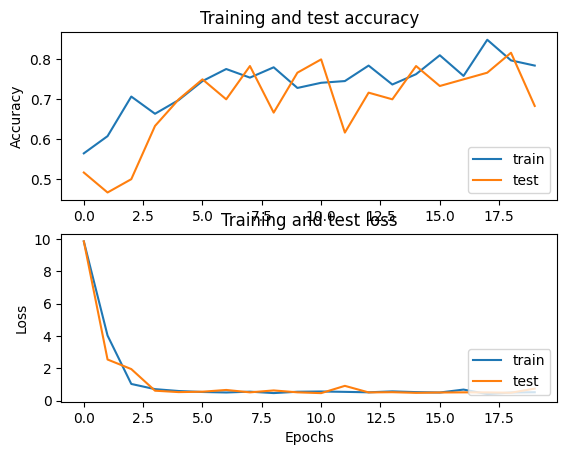

In [18]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()


## 5. Evaluating Performance

In this section we will investigate how it works on different parts.

In [19]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [20]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 36ms/step
Done inference!


In [22]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,0.999974
1,/content/medical-ai/images/Cardiomegaly/test/p...,00004893_085.jpg,pos,pos,0.999427
2,/content/medical-ai/images/Cardiomegaly/test/p...,00010381_000.jpg,pos,pos,0.999283
3,/content/medical-ai/images/Cardiomegaly/test/p...,00025969_000.jpg,pos,pos,0.998618
4,/content/medical-ai/images/Cardiomegaly/test/p...,00004344_013.jpg,pos,pos,0.998560


5a. Example image

1/1 [==============================] - 0s 24ms/step


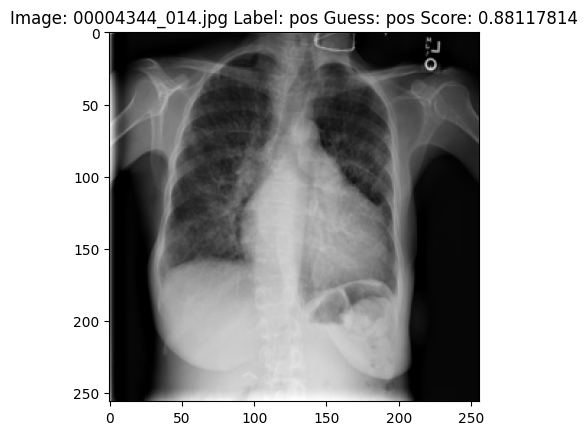

In [23]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

5b. Show Table of images

In [24]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.999974
5,00011557_003.jpg,pos,pos,0.998179
10,00005532_000.jpg,pos,pos,0.986681
15,00015304_001.jpg,pos,pos,0.977410
20,00019861_010.jpg,pos,pos,0.949963
25,00004342_023.jpg,pos,pos,0.909558
30,00000087_000.jpg,neg,pos,0.891783
35,00000090_006.jpg,neg,pos,0.855516
40,00015064_001.jpg,pos,pos,0.652866
45,00000080_000.jpg,neg,neg,0.485028


5c. Show histogram

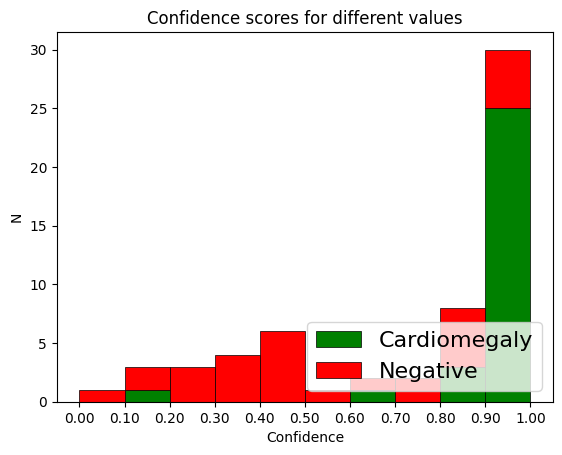

In [25]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

5d. Create cutoff point

In [28]:
cutoff = 0.29 #@param {type:"slider", min:0, max:1, step:0.01}

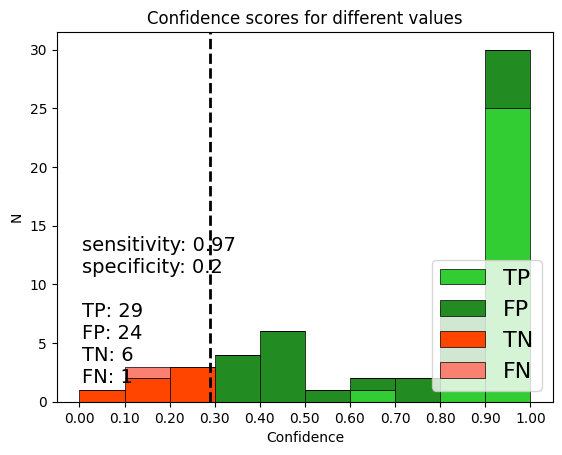

In [29]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff)

5e. Show ROC Curve

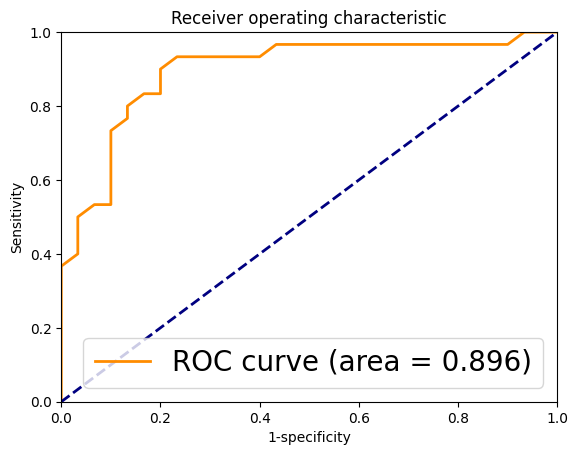

In [30]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

5f. Save Model

In [31]:
model.save('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

  adding: content/export/Cardiomegaly/ (stored 0%)
  adding: content/export/Cardiomegaly/assets/ (stored 0%)
  adding: content/export/Cardiomegaly/saved_model.pb (deflated 92%)
  adding: content/export/Cardiomegaly/variables/ (stored 0%)
  adding: content/export/Cardiomegaly/variables/variables.data-00000-of-00001 (deflated 49%)
  adding: content/export/Cardiomegaly/variables/variables.index (deflated 78%)
  adding: content/export/Cardiomegaly/keras_metadata.pb (deflated 96%)
  adding: content/export/Cardiomegaly/fingerprint.pb (stored 0%)


## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)